In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_excel("data_ysm.xlsx")
print(df.head())

   CARD_HOLDER FIRST_NAME      SURNAME     TRANS_ID  AMOUNT OP_DATE_PRECISE
1      2289906      AYTAC  AĞAKİŞİYEVA  TM758251134    1.00      23/08/2017
2      2289906      AYTAC  AĞAKİŞİYEVA  TM758251135    1.19      23/08/2017
3      2289906      AYTAC  AĞAKİŞİYEVA  TM758251136    2.18      23/08/2017
4      2289906      AYTAC  AĞAKİŞİYEVA  TM754884437   15.15      16/08/2017
5      2289906      AYTAC  AĞAKİŞİYEVA  TM758797131    1.52      24/08/2017


In [2]:
df1 = df

In [3]:
df1.TRANS_ID.nunique()

46086

In [4]:
df1.isnull().sum(axis=0)


CARD_HOLDER        0
FIRST_NAME         0
SURNAME            0
TRANS_ID           0
AMOUNT             0
OP_DATE_PRECISE    0
dtype: int64

In [5]:
df1.describe()

,CARD_HOLDER,AMOUNT
count,4.608600e+04,46086.000000
mean,1.993209e+06,121.111217
std,9.545358e+05,983.685744
min,5.000000e+01,0.000000
25%,1.277040e+06,5.000000
50%,2.336072e+06,15.500000
75%,2.843326e+06,66.497500
max,2.964055e+06,101357.900000


In [6]:
df1.head()

,CARD_HOLDER,FIRST_NAME,SURNAME,TRANS_ID,AMOUNT,OP_DATE_PRECISE
1,2289906,AYTAC,AĞAKİŞİYEVA,TM758251134,1.00,23/08/2017
2,2289906,AYTAC,AĞAKİŞİYEVA,TM758251135,1.19,23/08/2017
3,2289906,AYTAC,AĞAKİŞİYEVA,TM758251136,2.18,23/08/2017
4,2289906,AYTAC,AĞAKİŞİYEVA,TM754884437,15.15,16/08/2017
5,2289906,AYTAC,AĞAKİŞİYEVA,TM758797131,1.52,24/08/2017


In [7]:
import datetime as dt
NOW = dt.datetime(2018,10,24)


In [8]:
df1['OP_DATE_PRECISE'] = pd.to_datetime(df['OP_DATE_PRECISE'], format="%d/%m/%Y")
# Since recency is calculated for a point in time. The last invoice date is 2018-10-24, this is the date we will use to calculate recency.



In [9]:
df1['OP_DATE_PRECISE'].min()


Timestamp('2017-08-09 00:00:00')

In [10]:
df1['OP_DATE_PRECISE'].max()

Timestamp('2018-10-23 00:00:00')

In [11]:
# Create a RFM table
rfmTable = df1.groupby('CARD_HOLDER').agg({'OP_DATE_PRECISE': lambda x: (NOW - x.max()).days, # Recency
                                        'TRANS_ID': lambda x: x.count(),      # Frequency
                                        'AMOUNT': lambda x: x.sum()}) # Monetary Value

rfmTable['OP_DATE_PRECISE'] = rfmTable['OP_DATE_PRECISE'].astype(int)
rfmTable.rename(columns={'OP_DATE_PRECISE': 'recency', 
                         'TRANS_ID': 'frequency', 
                         'AMOUNT': 'monetary_value'}, inplace=True)



In [12]:
rfmTable.head()

,recency,frequency,monetary_value
CARD_HOLDER,,,
50,430,4,8.85
298,387,6,8085.22
815,418,1,23.00
949,417,1,2.00
964,399,1,170.00


In [13]:
quantiles = rfmTable.quantile(q=[0.20,0.40,0.60,0.80])
quantiles


,recency,frequency,monetary_value
0.2,82.0,2.0,60.792
0.4,385.0,4.0,197.720
0.6,390.0,8.0,493.240
0.8,407.0,18.0,1334.936


In [14]:
quantiles = quantiles.to_dict()
quantiles

{'recency': {0.2: 82.0, 0.4: 385.0, 0.6: 390.0, 0.8: 407.0},
 'frequency': {0.2: 2.0, 0.4: 4.0, 0.6: 8.0, 0.8: 18.0},
 'monetary_value': {0.2: 60.79200000000003,
  0.4: 197.72000000000003,
  0.6: 493.24000000000007,
  0.8: 1334.9360000000001}}

In [15]:
segmented_rfm = rfmTable

In [16]:
# Lowest recency, highest frequency and monetary are our best customers 
def RScore(x,p,d):
    if x <= d[p][0.20]:
        return 1
    elif x <= d[p][0.40]:
        return 2
    elif x <= d[p][0.60]: 
        return 3
    elif x <= d[p][0.80]: 
        return 4
    else:
        return 5
    
def FMScore(x,p,d):
    if x <= d[p][0.20]:
        return 5
    elif x <= d[p][0.40]:
        return 4
    elif x <= d[p][0.60]: 
        return 3
    elif x <= d[p][0.80]: 
        return 2
    else:
        return 1


In [17]:
segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))
# Add segment numbers to the RFM table



In [18]:
segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile
CARD_HOLDER,,,,,,
50,430,4,8.85,5,4,5
298,387,6,8085.22,3,3,1
815,418,1,23.00,5,5,5
949,417,1,2.00,5,5,5
964,399,1,170.00,4,5,4


In [19]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CARD_HOLDER,,,,,,,
50,430,4,8.85,5,4,5,545
298,387,6,8085.22,3,3,1,331
815,418,1,23.00,5,5,5,555
949,417,1,2.00,5,5,5,555
964,399,1,170.00,4,5,4,454


In [20]:
# Here is top 10 of our best customers!
segmented_rfm[segmented_rfm['RFMScore']=='111'].sort_values('monetary_value', ascending=False).head(10)


,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CARD_HOLDER,,,,,,,
2681849,2,164,323580.06,1,1,1,111
570546,1,706,141942.00,1,1,1,111
2716234,1,124,140984.00,1,1,1,111
1956620,2,106,48975.53,1,1,1,111
2808062,3,183,46111.62,1,1,1,111
2835510,2,81,45676.50,1,1,1,111
2851635,80,59,41654.14,1,1,1,111
546774,3,134,26479.42,1,1,1,111
2685646,2,44,25631.05,1,1,1,111


In [21]:
rfm_scores = segmented_rfm.iloc[:,3:6]


In [25]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
normalized_rfm = rfmTable.iloc[:, 0:3]
normalized_rfm = scaler.fit_transform(rfmTable.iloc[:, 0:3])
normalized_rfm = pd.DataFrame(normalized_rfm)
normalized_rfm.columns = ['recency', 'frequency', 'monetary_value']
# cluster the data into five clusters
dbscan = DBSCAN(eps=0.8, min_samples = 10)
clusters = dbscan.fit_predict(normalized_rfm)



In [26]:
rfmTable['clusters'] = clusters
rfmTable.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore,clusters
CARD_HOLDER,,,,,,,,
50,430,4,8.85,5,4,5,545,0
298,387,6,8085.22,3,3,1,331,0
815,418,1,23.00,5,5,5,555,0
949,417,1,2.00,5,5,5,555,0
964,399,1,170.00,4,5,4,454,0


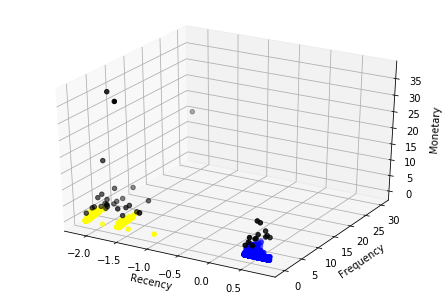

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(2)
ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig)

#ax.scatter(normalized_rfm.recency, normalized_rfm.frequency, normalized_rfm.monetary_value, s=30)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

colors = ['blue', 'yellow', 'green', 'red', 'black']

for i in range(-1,4):
    ax.scatter(normalized_rfm.recency[(rfmTable.clusters == i).values], normalized_rfm.frequency[(rfmTable.clusters == i).values], normalized_rfm.monetary_value[(rfmTable.clusters == i).values], c = colors[i])
    
#ax.scatter(normalized_rfm.recency[rfmTable.clusters == -1], normalized_rfm.frequency[rfmTable.clusters == -1], normalized_rfm.monetary_value[rfmTable.clusters == -1], c = 'black')
